# 第10回: RNN (Check1)
## 概要
講義で紹介したLSTM, GRUを実際に実装してみましょう。

この少演習では、講師が実際にコードを書いていくので、真似する形で進めてください。
## 目標
- Chainerで多層のLSTMを実装する

In [1]:
%matplotlib inline
import chainer
from chainer import cuda, Function
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
import numpy as np
import matplotlib.pyplot as plt

### 一層のLSTM
LSTMセルの数が一つのものを、一層のLSTMと呼びます。
まずは一層のLSTMを実装してみましょう。[LSTMのリンク](https://docs.chainer.org/en/stable/reference/generated/chainer.links.LSTM.html#chainer.links.LSTM)は`L.LSTM`にあります。

In [2]:
class SingleLSTM(Chain):
    def __init__(
        self,
        n_input,
        n_hidden,
        n_output,
        train=True
    ):
        super(SingleLSTM, self).__init__()
        with self.init_scope():
            self.l0 = L.Linear(n_input, n_hidden)  # COUT
            self.l1 = L.LSTM(n_hidden, n_hidden)  # COUT
            self.l2 = L.Linear(n_hidden, n_output)  # COUT
            
    def __call__(self, x):
        u = self.l0(x)  # COUT
        h = self.l1(u)  # COUT
        y = self.l2(h)  # COUT
        return y
    
    def clear_state(self):
        self.l1.reset_state()  # COUT

### 多層のLSTM

これを多層化する場合、単純にLinkをつなぎ合わせていけば良いことになります。(例: 二層のLSTM)

多層化すると、より次元の高い複雑なデータを学習することが出来ますが、闇雲に層を増やしディープにしてもあまりうまく行きません。
とりわけLSTM等RNNの場合、高々4層の構造を取ることが多く、CNNのようにバンバン重ねるということはしないのが普通です。

In [3]:
class MultiLSTM(Chain):
    def __init__(
        self,
        n_input,
        n_hidden,
        n_output,
        train=True
    ):
        super(MultiLSTM, self).__init__()
        with self.init_scope():
            self.l0 = L.Linear(n_input, n_hidden)  # COUT
            self.l1 = L.LSTM(n_hidden, n_hidden)  # COUT
            self.l2 = L.LSTM(n_hidden, n_hidden)
            self.l3 = L.Linear(n_hidden, n_output)  # COUT
            
    def __call__(self, x):
        u = self.l0(x)  # COUT
        h1 = self.l1(u)  # COUT
        h2 = self.l2(h1)
        y = self.l3(h)  # COUT
        return y
    
    def clear_state(self):
        self.l1.reset_state()  # COUT
        self.l2.reset_state()  # cout

### 多層のGRU
LSTMの代わりにGRUを使いたくなった場合でも、実装は非常に簡単で、`L.LSTM`の代わりに`L.GRU`を用いれば良いだけです。

その他使えるリンクは、こちらの[docs](https://docs.chainer.org/en/stable/reference/links.html)に列挙されています。

In [4]:
class MultiGRU(Chain):
    def __init__(
        self,
        n_input,
        n_hidden,
        n_output,
        train=True
    ):
        super(MultiGRU, self).__init__()
        with self.init_scope():
            self.l0 = L.Linear(n_input, n_hidden)  # COUT
            self.l1 = L.GRU(n_hidden, n_hidden)  # COUT
            self.l2 = L.GRU(n_hidden, n_hidden)
            self.l3 = L.Linear(n_hidden, n_output)  # COUT
            
    def __call__(self, x):
        u = self.l0(x)  # COUT
        h1 = self.l1(u)  # COUT
        h2 = self.l2(h1)
        y = self.l3(h)  # COUT
        return y
    
    def clear_state(self):
        self.l1.reset_state()  # COUT
        self.l2.reset_state()  # cout

### 正弦波の作製

In [5]:
import math
import random
 
random.seed(0)
 
class DataMaker(object):
 
    def __init__(self, steps_per_cycle, number_of_cycles):
        self.steps_per_cycle = steps_per_cycle
        self.number_of_cycles = number_of_cycles
 
    def make(self):
        return np.array([math.sin(i * 2 * math.pi/self.steps_per_cycle) for i in range(self.steps_per_cycle)] * self.number_of_cycles)

In [25]:
# make training data
data_maker = DataMaker(steps_per_cycle=50, number_of_cycles=30)
train_data = data_maker.make()

In [26]:
train_data

array([ 0.        ,  0.12533323,  0.24868989, ..., -0.36812455,
       -0.24868989, -0.12533323])

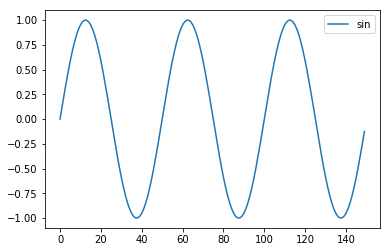

In [27]:
plt.plot(train_data[:50*3],  label='sin')
plt.legend()
plt.show()

### 学習
実際にデータを学習していきましょう。

In [9]:
model = SingleLSTM(n_input=1, n_hidden=50, n_output=1)
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [10]:
import cupy as xp
# !!! FOR GPU !!!
gpu_device = 0
cuda.get_device(gpu_device).use()
model.to_gpu(gpu_device)

In [11]:
def get_loss(model, x_in):
    loss_accum = 0
    x = xp.array(x_in, dtype=xp.float32)
    for i in range(len(x_in) - 1):
        x_k = xp.atleast_2d(x[i])
        y_t = xp.atleast_2d(x[i+1])
        y_k = model(x_k)
        loss = F.mean_squared_error(y_k, y_t)
        loss_accum += loss
    return loss_accum

In [12]:
loss_results = []
train_x = xp.array(train_data, dtype=xp.float32).reshape((-1, 1))
for e in range(50):
    model.zerograds()  # initialize gradients
    loss = get_loss(model, train_x)  # get loss
    loss.backward()  # compute backpropag
    loss_results += [loss.data]
    optimizer.update()
    print('epoch: {:2d}, loss: {:.3f}'.format(e, float(loss.data)))

epoch:  0, loss: 1260.022
epoch:  1, loss: 954.129
epoch:  2, loss: 732.836
epoch:  3, loss: 564.250
epoch:  4, loss: 430.813
epoch:  5, loss: 324.159
epoch:  6, loss: 239.874
epoch:  7, loss: 175.682
epoch:  8, loss: 129.702
epoch:  9, loss: 98.911
epoch: 10, loss: 79.490
epoch: 11, loss: 67.799
epoch: 12, loss: 60.819
epoch: 13, loss: 56.263
epoch: 14, loss: 52.586
epoch: 15, loss: 48.924
epoch: 16, loss: 44.994
epoch: 17, loss: 40.939
epoch: 18, loss: 37.129
epoch: 19, loss: 33.947
epoch: 20, loss: 31.613
epoch: 21, loss: 30.091
epoch: 22, loss: 29.114
epoch: 23, loss: 28.303
epoch: 24, loss: 27.327
epoch: 25, loss: 26.001
epoch: 26, loss: 24.301
epoch: 27, loss: 22.313
epoch: 28, loss: 20.161
epoch: 29, loss: 17.966
epoch: 30, loss: 15.824
epoch: 31, loss: 13.820
epoch: 32, loss: 12.032
epoch: 33, loss: 10.529
epoch: 34, loss: 9.360
epoch: 35, loss: 8.530
epoch: 36, loss: 7.985
epoch: 37, loss: 7.626
epoch: 38, loss: 7.324
epoch: 39, loss: 6.967
epoch: 40, loss: 6.486
epoch: 41, lo

### 評価

In [13]:
model.clear_state()
with chainer.no_backprop_mode():
        out = model(train_data)

In [19]:
type(out)

chainer.variable.Variable

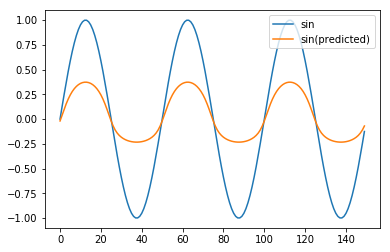

In [28]:
plt.plot(train_data[:50*3],  label='sin')
plt.plot(chainer.cuda.to_cpu(out.data)[:50*3],  label='sin(predicted)')
plt.legend()
plt.show()